In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("dataset.csv")

In [3]:
df.head(2)

,PWM,V,I,w
0,0,12.6,0.21,0.0
1,0,12.3,0.22,0.0


In [4]:
v =  [12.6, 12.3, 12, 11.7, 11.4, 11.1, 10.8, 10.5, 10.2, 9.9]

In [23]:
#To select rows whose column value is in list 
lst_V = [12,  12.3, 11.7]
voltages = df[df.V.isin(lst_V)]
voltages.head(2)

,PWM,V,I,w
1,0,12.3,0.22,0.0
2,0,12.0,0.22,0.0


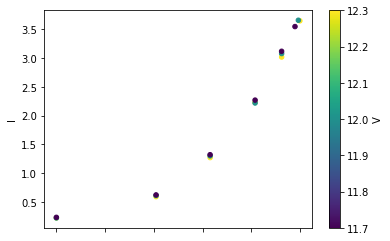

In [24]:
voltages.plot.scatter(x = 'w', y ='I', c = 'V',colormap='viridis')

In [28]:
arr = np.polyfit(x = voltages['w'], y = voltages['I'], deg = 4, rcond=None, full=False, w=None, cov=False)
arr *= 12

In [29]:
arr

array([-1.12440383e-11,  2.61252127e-07,  2.69216676e-05,  6.28905764e-03,
        2.67826168e+00])

In [15]:
from numpy import linalg, zeros, ones, hstack, asarray
import itertools

def basis_vector(n, i):
    """ Return an array like [0, 0, ..., 1, ..., 0, 0]

    >>> from multipolyfit.core import basis_vector
    >>> basis_vector(3, 1)
    array([0, 1, 0])
    >>> basis_vector(5, 4)
    array([0, 0, 0, 0, 1])
    """
    x = zeros(n, dtype=int)
    x[i] = 1
    return x

def as_tall(x):
    """ Turns a row vector into a column vector """
    return x.reshape(x.shape + (1,))

def multipolyfit(xs, y, deg, full=False, model_out=False, powers_out=False):
    """
    Least squares multivariate polynomial fit

    Fit a polynomial like ``y = a**2 + 3a - 2ab + 4b**2 - 1``
    with many covariates a, b, c, ...

    Parameters
    ----------

    xs : array_like, shape (M, k)
         x-coordinates of the k covariates over the M sample points
    y :  array_like, shape(M,)
         y-coordinates of the sample points.
    deg : int
         Degree o fthe fitting polynomial
    model_out : bool (defaults to True)
         If True return a callable function
         If False return an array of coefficients
    powers_out : bool (defaults to False)
         Returns the meaning of each of the coefficients in the form of an
         iterator that gives the powers over the inputs and 1
         For example if xs corresponds to the covariates a,b,c then the array
         [1, 2, 1, 0] corresponds to 1**1 * a**2 * b**1 * c**0

    See Also
    --------
        numpy.polyfit

    """
    y = asarray(y).squeeze()
    rows = y.shape[0]
    xs = asarray(xs)
    num_covariates = xs.shape[1]
    xs = hstack((ones((xs.shape[0], 1), dtype=xs.dtype) , xs))

    generators = [basis_vector(num_covariates+1, i)
                            for i in range(num_covariates+1)]

    # All combinations of degrees
    powers = map(sum, itertools.combinations_with_replacement(generators, deg))

    # Raise data to specified degree pattern, stack in order
    A = hstack(asarray([as_tall((xs**p).prod(1)) for p in powers]))

    beta = linalg.lstsq(A, y)[0]

    if model_out:
        return mk_model(beta, powers)

    if powers_out:
        return beta, powers
    return beta

def mk_model(beta, powers):
    """ Create a callable python function out of beta/powers from multipolyfit

    This function is callable from within multipolyfit using the model_out flag
    """
    # Create a function that takes in many x values
    # and returns an approximate y value
    def model(*args):
        num_covariates = len(powers[0]) - 1
        if len(args)!=(num_covariates):
            raise ValueError("Expected %d inputs"%num_covariates)
        xs = asarray((1,) + args)
        return sum([coeff * (xs**p).prod()
                             for p, coeff in zip(powers, beta)])
    return model

def mk_sympy_function(beta, powers):
    from sympy import symbols, Add, Mul, S
    num_covariates = len(powers[0]) - 1
    xs = (S.One,) + symbols('x0:%d'%num_covariates)
    return Add(*[coeff * Mul(*[x**deg for x, deg in zip(xs, power)])
                        for power, coeff in zip(powers, beta)])
